In [1]:
###########################################################################################################################
# Notebook  Detail: This notebook is the implementation an efficient algorithm for the detection and classification of 
# Diabetic Retinopathy.
# Written by      :   Athira T R
# Guided by       :   Dr.Jyothisha Nair
# Reg No          :   AM.EN.P2ARI20010
# Email           :   amenp2ari20010@am.students.amrita.edu
############################################################################################################################

# I. INTRODUCTION
This notebook is the implementation an efficient algorithm using the  approach of  transfer  learning in  an ArtificialNeural Network for the detection  and classification of Diabetic Retinopathy into 3 classes - No DR, NPDR, PDR  and analysis of the results by testing it on a set of unseen images.ThreadPooling statergy is used to reduce the time of preprocessing by a factor of one by four Later the anlysis of the same as a 3 level classification problem and 2 level Detection Problem.

As each section has multiple steps involved, the notebook is divided into 5 major sections for the ease of undersanding :
1. EXPLORATORY DATA ANALYSIS
2. PREPROCESSING
3. AUGMENTATION
4. VISUALIZATION - PCA & TSNE
5. NEURAL NETWORK MODELING AND TRAINING
6. TESTING AND EVALUATION

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing basic Libraries
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
import pickle
import os
import time

# importing Visualization Libraries
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# importing Image Libraries
from PIL import Image
import cv2

# importing Deep Learning Libraries
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import tensorflow as tf

# importing sklearn Libraries
from sklearn.model_selection import train_test_split

# importing multiprocessing Libraries
from multiprocessing.pool import ThreadPool

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 1. EXPLORATORY DATA ANALYSIS

In [ ]:
# function to create a dataframe with the name of the image, complete file path and diagonostic label[0- No DR, 1-NPDR, 2-PDR]
def create_df():
    data = pd.read_csv('/content/drive/MyDrive/DR/3_class.csv')
    data_dir = os.path.join('./','/content/drive/MyDrive/DR/train_images')

    data['file_path'] = data['id_code'].map(lambda x: os.path.join(data_dir,'{}.png'.format(x)))    
    data['file_name'] = data["id_code"].apply(lambda x: x + ".png")
    data['diagnosis'] = data['diagnosis'].astype(str)
    
    return data

In [ ]:
data = create_df()
data.head(10)

id_code  ...         file_name
0  000c1434d8d7  ...  000c1434d8d7.png
1  001639a390f0  ...  001639a390f0.png
2  002c21358ce6  ...  002c21358ce6.png
3  005b95c28852  ...  005b95c28852.png
4  0083ee8054ee  ...  0083ee8054ee.png
5  0097f532ac9f  ...  0097f532ac9f.png
6  00a8624548a9  ...  00a8624548a9.png
7  00b74780d31d  ...  00b74780d31d.png
8  00cc2b75cddd  ...  00cc2b75cddd.png
9  00e4ddff966a  ...  00e4ddff966a.png

[10 rows x 4 columns]

In [ ]:
data.shape

(3099, 4)

#### DATASET FREQUENCY PLOTS

In [ ]:
# This function is used to create a pie chart to show the data distribution with respect to various classes

def class_frequency(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    # Creating dataset
    diagnosis = df_group['diagnosis']
      
    data = df_group['count']
      
    # Creating explode data
    explode = (0.05, 0.05, 0.05)
      
    # Creating color parameters
    colors = ( "steelblue", "darksalmon", "limegreen")

    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "grey" }
      
    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)
        
    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data, 
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode, 
                                      labels = cars,
                                      shadow = True,
                                      colors = colors,
                                      startangle = 90,
                                      wedgeprops = wp,
                                      textprops = dict(color ="black"))  
    # Adding legend
    ax.legend(wedges, diagnosis,
              title ="diagnosis class",
              loc ="center left",
              bbox_to_anchor =(1, 0, 0.5, 1))
      
    plt.setp(autotexts, size = 15)
    ax.set_title("Class distribution in "+ title +" data")
      
    # show plot
    plt.show()

In [ ]:
# creating train (80%), test split(20%)
df_train, df_test = train_test_split(data, test_size=0.2)
df_train.shape, df_test.shape

((2479, 4), (620, 4))

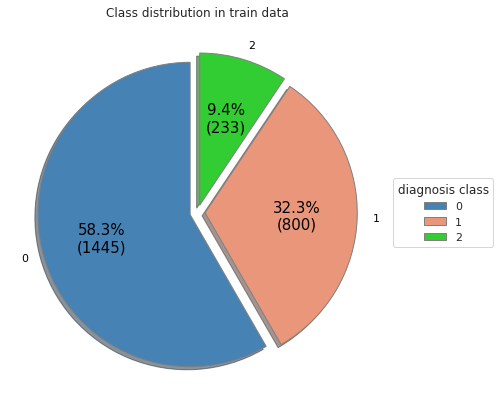

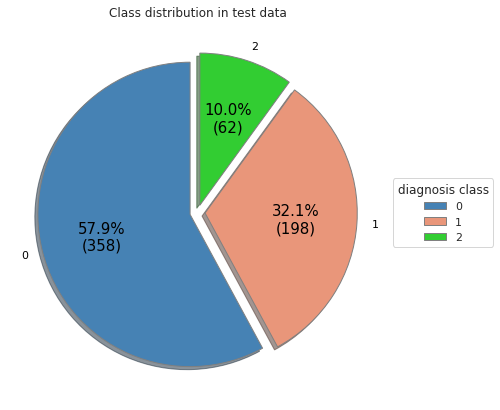

In [ ]:
class_frequency(df_train, "train")
class_frequency(df_test, "test")

The plots clearly shows that the dataset is unbalanced data. Hence to reduce the possible bias during training we augment the data in  the preprocessing stage. 

# 2.  IMAGE  PREPROCESSING

Preprocessing involves 4 processes
1. Image resizing
2. Grey channel extraction
3. Gaussian blur 
4. Circular Cropping

Due to the huge amount of data [10 GB], to reduce the time for preprocessing Theadpooling was used.It offers a convenient means of parallelizing the execution of a function across multiple input values, distributing the input data across processes (data parallelism) on different cores


#### 1&2. Image resizing & Grey channel extraction


In [ ]:
IMG_SIZE = 200

In [ ]:
# This function converts the inages to grey scale
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

In [ ]:
# This function is used to visualize the preprocessed data in the form of a grid, classwise for easy visual inspection.
def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,3,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2)])]
        for i in range(3):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()


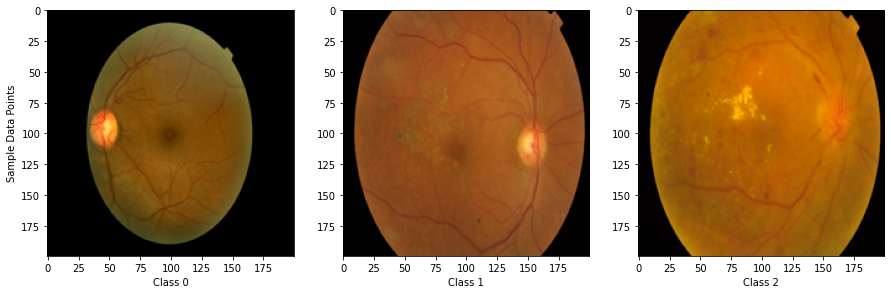

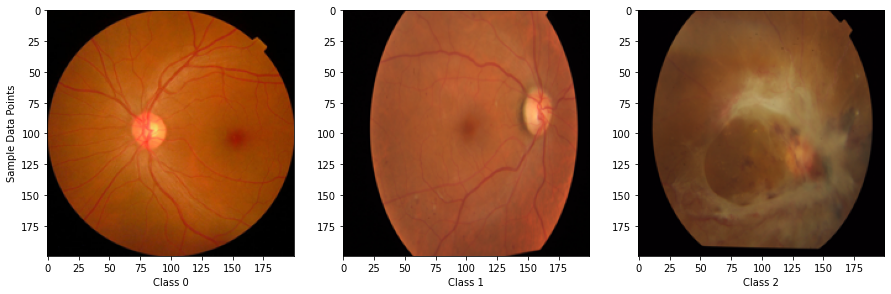

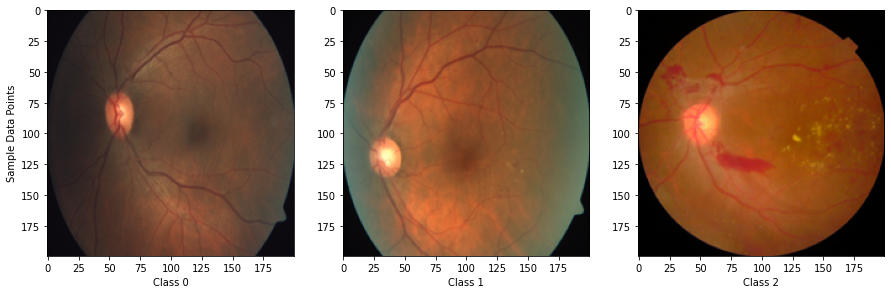

In [ ]:
# Sample data for all the three classes without any preprocessing
visualize_imgs(df_train,3,color_scale = None)

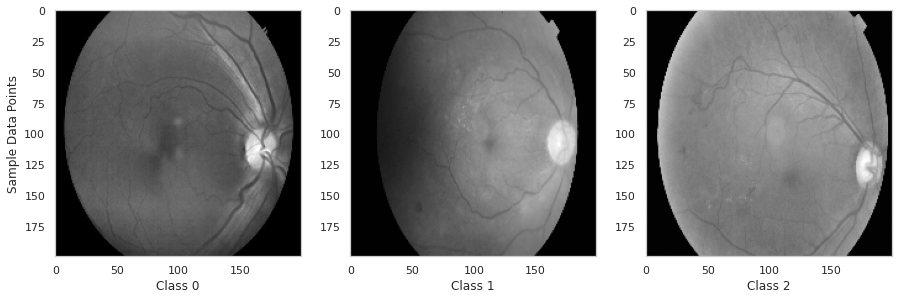

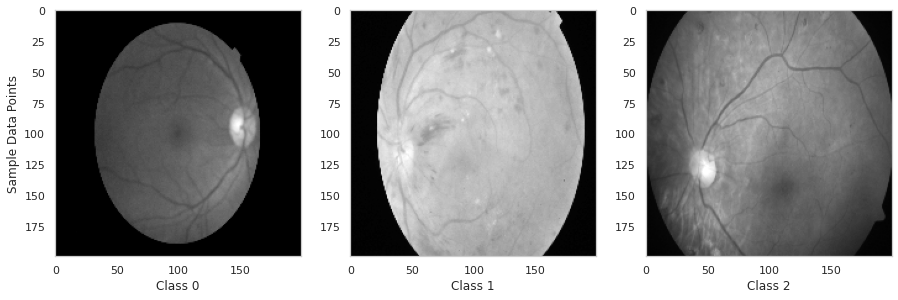

In [ ]:
# Sample data for all the three classes after gray scaling
visualize_imgs(df_train,2,color_scale = 'gray')

It is evident that grey scaling enhances the exudate because of its bright nature

#### 3. GAUSSIAN BLUR

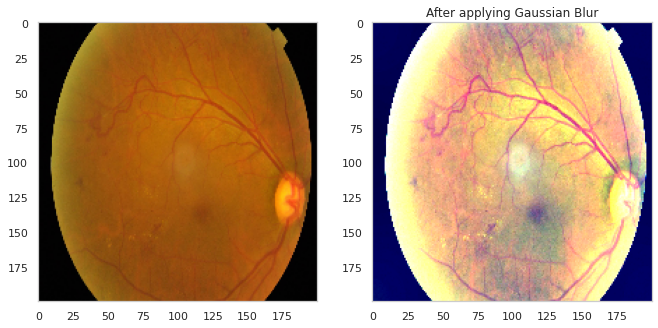

In [ ]:
# appling Gaussian Filter on the image

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
plt.title('After before Gaussian Blur')
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

GaussianBlur()    function    from    OpenCV    was utilized     specifyingsrcas     the     resized input     image, andsigmaXwhich is the Gaussian kernel standard deviation in  X  direction  as  30.After  applying  Gaussian  filter,  the more  focus  is  given  to  the  information  contained  in  the center  of  the  image.To  sharpen  the  edges  of  the  image obtained   after Gaussian   blur,addWeighted()function   of OpenCV is used. From the results it is evident that Gaussing filtering with the right parameters greatly enhances the blood vessel feature along with red lesions

In [ ]:
# This function crops out the areas that contains some information and masks any of the unwanted areas
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

To    give    more    focus    to    the    part    containing    the fundusimageof the eye, a circular cropping is applied to all the images to remove  unnecessary background and to make a uniform training dataset

In [ ]:
# function to do  grey channel filtering , circular cropping and gaussian glur altogether
def circle_crop(img, sigmaX):   
 
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

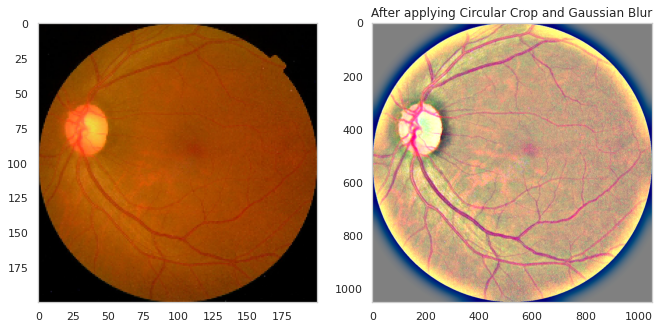

In [ ]:
# Showing sample results before and after preprocessing
rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
#plt.title('Before applying Circular Crop and Gaussian Blur')
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

#### Circular Crop and Gaussian Blur

If  we  have  a colorimage,  in  order  to apply circular cropping, the image is first converted to grey scale  and  a  mask  is  created  which  would  pass  only  those pixel   values   of   the   image,   which   are   greater   than   the specified  tolerance  value.  In  cases  where  the  image  is  too dark,  we  return  the  original  image  in  order  to  avoid  the cropping of the entire image. In the other case, the Boolean array  obtained  after  applying  the  masking  can  be  used  to index  into the  image  data  for  extraction  of  valid  boundingbox    using    broadcasted    indexing    with np.ix_.    And    a cv2.bitwise_and() operation is done between this image and the dummy circle created for doing the circular cropping.

In [ ]:
#function for visualizing the images classwise after gaussian blur and circular cropping 
def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,3,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2)])]
        for i in range(3):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

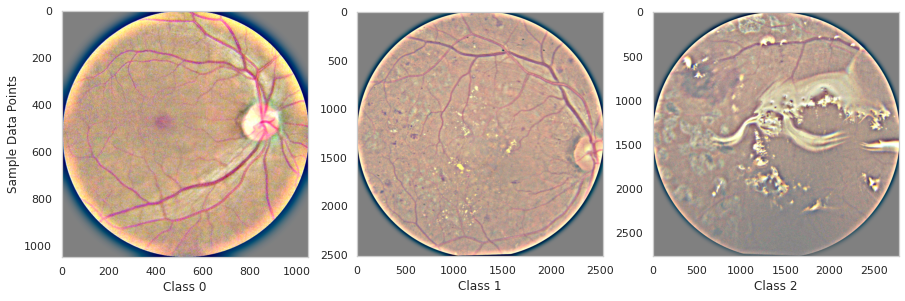

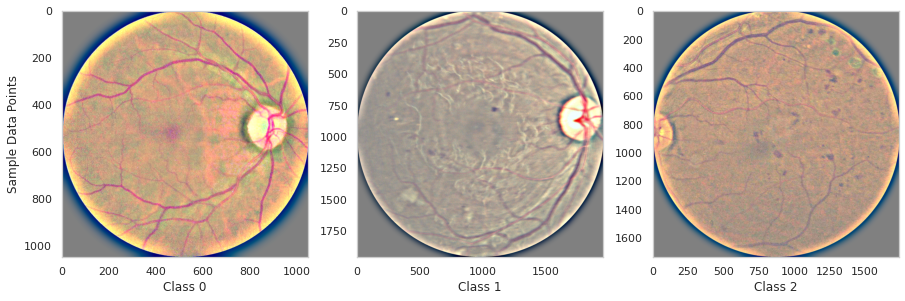

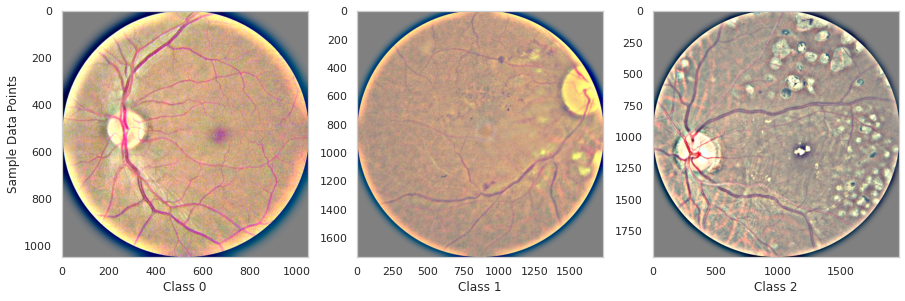

In [ ]:
visualize_img_process(df_train,3,sigmaX = 30)

It can be seen that after all preprocessing the exudates, bloodvessels and red lesions visibilty has been increased to great extend

# 3. AUGMENTATION

To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc. As our dataset is  unbalenced in terms of class distribution it is highly recommended

In [ ]:
# function to do data augmentation
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

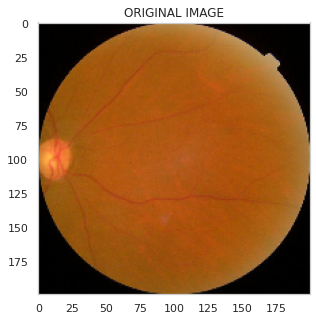

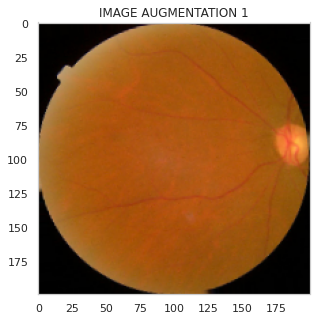

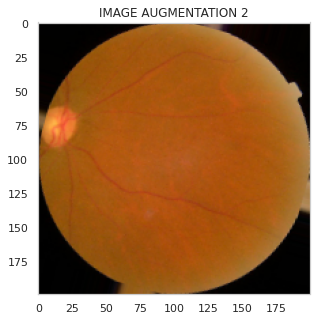

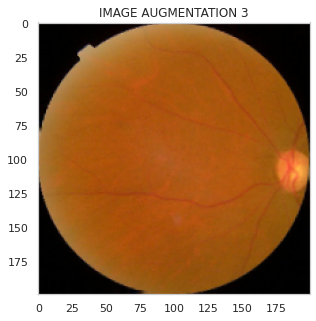

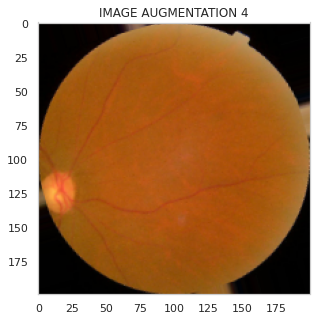

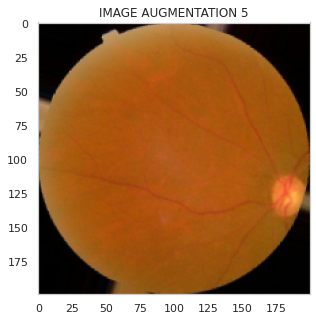

In [ ]:
# Sample results by augmenting data by rotating the images in steps of 20 degrees
generate_augmentations(5)

# 4. VISUALIZATION TECHNIQUES - PCA & TSNE

## 1. PCA - Principal component analysis

Principal   component   analysis   (PCA)is   a   dimensionality reduction  technique    for  dataset  used  for  increasing    the interpretability  but  at  the  cost  of  minimizing  information loss   to   a   certain   extend.   It   does   it   by   creating   new uncorrelated variables  which  maximize  variance  that  are linear  combinations  of  the  initial  variables.    PCA  plots shows  clusters  of  samples  supporting  their  similarity.  PCA does   not   discard   any   samples   or   variables.   Instead,   it reduces  the  huge  number  of  initial  dimensions  by  creating principal components (PCs)

In [ ]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    

  0%|          | 0/3099 [00:00<?, ?it/s]

In [ ]:
nsamples, nx, ny = X_train.shape
nsamples, nx, ny

(3099, 224, 224)

In [ ]:
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

# defining 2 component PCA
pca=PCA(2)

X_proj=pca.fit_transform(d2_train_dataset)

data_target = df_train.diagnosis
data_target = pd.to_numeric(data_target)


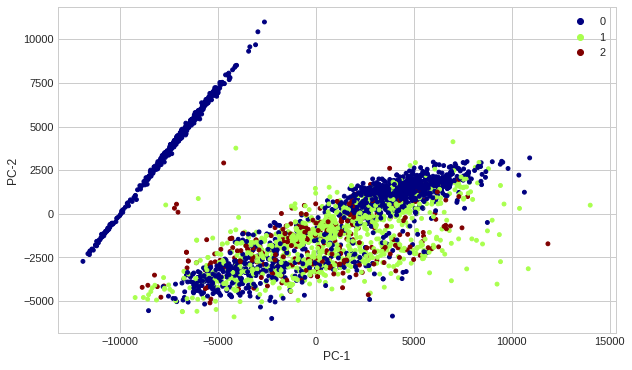

In [ ]:
# PCA plot
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], s = 15,
            cmap = c_map , c = data_target)
#plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
classes = ['0', '1', '2']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.show()

##2. TSNE - t-Distributed Stochastic Neighbor Embedding 


t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data.t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. Finally, t-SNE calculates the similarity probability score in a low dimensional space in order to cluster the points together.

In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

  0%|          | 0/8 [00:00<?, ?it/s]

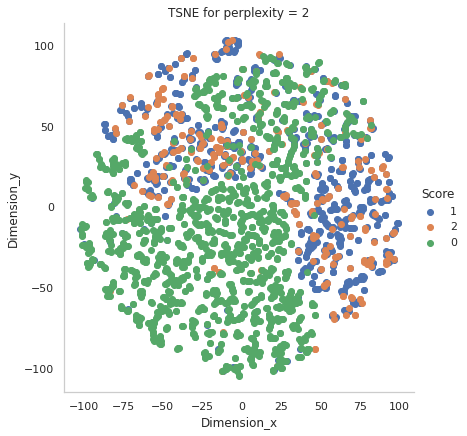

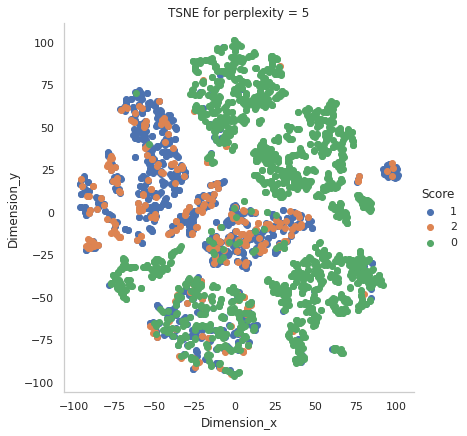

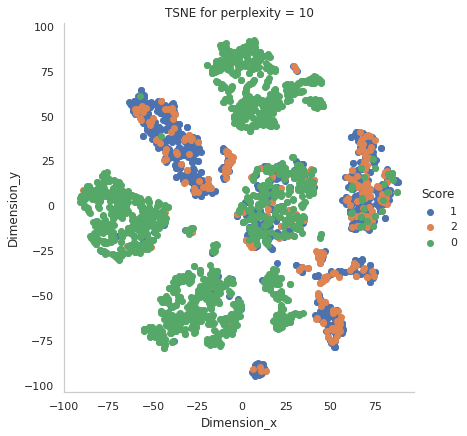

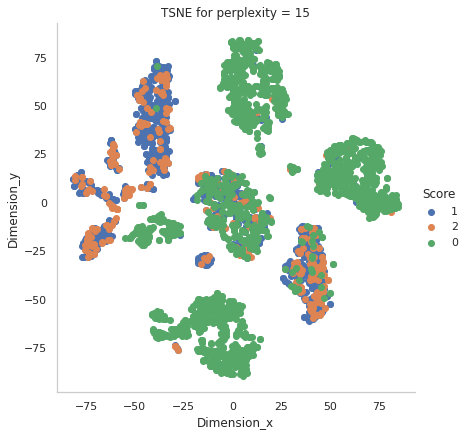

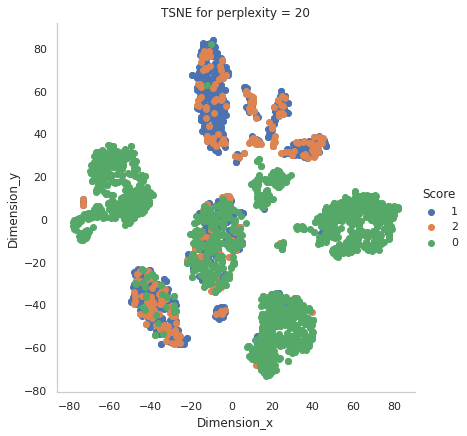

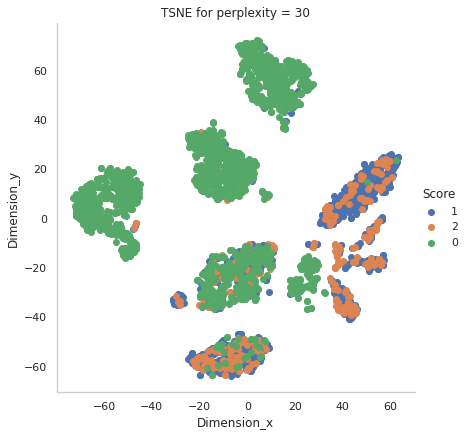

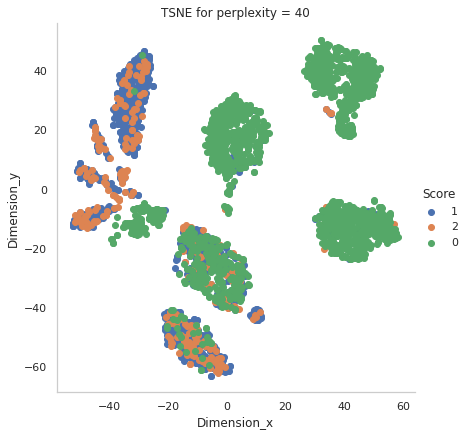

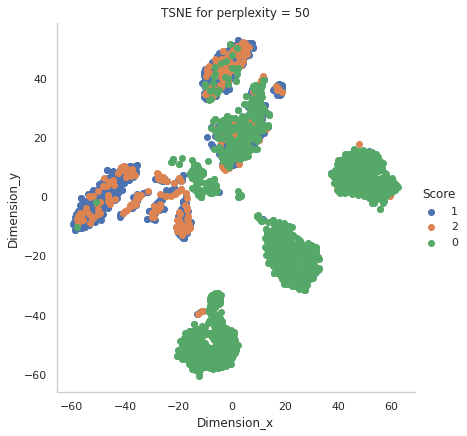

In [ ]:
# perplexity values to iterate
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

Conclusion from both visualizations : The PCA and TSNE plot gives  an intution on how seperable or convoluted the feature space is from the plot it is evident that most convelutes classes are class1 and class2.

#### Creating train and test pickle files

In [ ]:
file = open('df_train', 'wb')
pickle.dump(df_train, file)
file.close()

In [ ]:
file = open('df_train', 'rb')
df_train = pickle.load(file)
file.close()

In [ ]:
file = open('df_test', 'wb')
pickle.dump(df_test, file)
file.close()

In [ ]:
file = open('df_test', 'rb')
df_test = pickle.load(file)
file.close()

In [ ]:
print(df_train.shape,df_test.shape)

(2479, 4) (620, 4)


##### Saving preprocessed data for future use

In [ ]:
IMG_SIZE  = 512

In [ ]:
# Function to resizing the images folderwise
def image_resize_save(file):
    input_filepath = os.path.join('./','/content/gdrive/MyDrive/DR/train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','/content/gdrive/MyDrive/DR/test_images_resized1','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
# Support function to run multiple processes - parellel processing
def multiprocess_image_downloader(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results

In [ ]:
# run 6 parellel processes
multiprocess_image_downloader(6, list(df_train_test.id_code.values))

### SAVING PREPROCESSED DATA

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
 
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','test_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def multiprocess_image_processor(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [ ]:
cd ..


In [ ]:
ls | wc -l

In [ ]:
pwd

In [ ]:
# Use 6 cores
multiprocess_image_processor(6, list(df_train_test.id_code.values))

# NEURAL NETWORK MODELING AND TRAINING - RESNET base

In [ ]:
# initialize Model parameters
BATCH_SIZE = 8
EPOCHS = 200
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 0.0001
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
N_CLASSES

3

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rotation_range=20, rescale=1./255, horizontal_flip=True,validation_split=0.15)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="/content/drive/MyDrive/DR/train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training',
                                                      shuffle=True)
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="/content/drive/MyDrive/DR/train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory = "/content/drive/MyDrive/DR/train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train,df_test)

Found 1679 validated image filenames belonging to 3 classes.
Found 296 validated image filenames belonging to 3 classes.
Found 497 validated image filenames.


In [ ]:
def create_model(input_shape, n_out):

    input_tensor = Input(shape=input_shape)

    base_model = ResNet50(weights='imagenet')

    model = Sequential()
    model.add(base_model)
    model.add(Dense(512, activation='relu', input_dim=input_shape))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='sigmoid'))

    model.summary()
    
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = True

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 26,413,419
Trainable params: 26,360,299
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential"
__________________

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
startTime = time.time()
history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history
elapsedTime = time.time() - startTime
print("elapsedTime : ", elapsedTime)

Epoch 1/2
209/209 [==============================] - 1719s 8s/step - loss: 0.7223 - accuracy: 0.7899 - val_loss: 0.9479 - val_accuracy: 0.5541
Epoch 2/2
209/209 [==============================] - 35s 166ms/step - loss: 0.4676 - accuracy: 0.8330 - val_loss: 0.9421 - val_accuracy: 0.5541


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]

#callback_list = [es]
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 1539      
Total params: 26,413,419
Trainable params: 26,360,299
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
startTime = time.time()
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          #callbacks=callback_list,
                                          verbose=1).history
elapsedTime = time.time() - startTime
print("elapsedTime : ", elapsedTime)

Epoch 1/200
209/209 [==============================] - 40s 170ms/step - loss: 0.4655 - accuracy: 0.7002 - val_loss: 0.5862 - val_accuracy: 0.5541
Epoch 2/200
209/209 [==============================] - 34s 164ms/step - loss: 0.3657 - accuracy: 0.7786 - val_loss: 0.8446 - val_accuracy: 0.4155
Epoch 3/200
209/209 [==============================] - 35s 166ms/step - loss: 0.3627 - accuracy: 0.7678 - val_loss: 0.8054 - val_accuracy: 0.5372
Epoch 4/200
209/209 [==============================] - 35s 165ms/step - loss: 0.3123 - accuracy: 0.7989 - val_loss: 0.6690 - val_accuracy: 0.6216
Epoch 5/200
209/209 [==============================] - 34s 164ms/step - loss: 0.2652 - accuracy: 0.8348 - val_loss: 1.1488 - val_accuracy: 0.5642
Epoch 6/200
209/209 [==============================] - 34s 164ms/step - loss: 0.2924 - accuracy: 0.8085 - val_loss: 0.3430 - val_accuracy: 0.8108
Epoch 7/200
209/209 [==============================] - 35s 165ms/step - loss: 0.2610 - accuracy: 0.8336 - val_loss: 1.2586 -

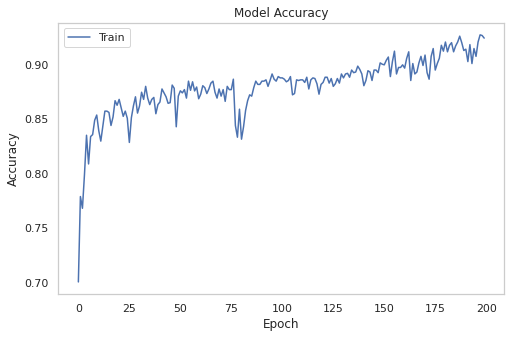

In [ ]:
# plot for training accuracy
plt.figure(figsize=(8,5))
plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
startTime = time.time()
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=30,
                                          #callbacks=callback_list,
                                          verbose=1).history
elapsedTime = time.time() - startTime
print("elapsedTime : ", elapsedTime)

Epoch 1/30
209/209 [==============================] - 34s 164ms/step - loss: 0.0959 - accuracy: 0.9431 - val_loss: 0.2128 - val_accuracy: 0.9088
Epoch 2/30
209/209 [==============================] - 34s 162ms/step - loss: 0.1013 - accuracy: 0.9437 - val_loss: 0.2823 - val_accuracy: 0.8480
Epoch 3/30
209/209 [==============================] - 34s 163ms/step - loss: 0.1045 - accuracy: 0.9354 - val_loss: 0.4902 - val_accuracy: 0.8007
Epoch 4/30
209/209 [==============================] - 34s 163ms/step - loss: 0.0942 - accuracy: 0.9461 - val_loss: 0.6774 - val_accuracy: 0.8446
Epoch 5/30
209/209 [==============================] - 34s 162ms/step - loss: 0.1039 - accuracy: 0.9485 - val_loss: 0.8875 - val_accuracy: 0.7838
Epoch 6/30
209/209 [==============================] - 34s 163ms/step - loss: 0.1014 - accuracy: 0.9449 - val_loss: 0.1909 - val_accuracy: 0.8986
Epoch 7/30
209/209 [==============================] - 34s 163ms/step - loss: 0.0918 - accuracy: 0.9449 - val_loss: 0.1412 - val_ac

In [ ]:
startTime = time.time()
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=50,
                                          #callbacks=callback_list,
                                          verbose=1).history
elapsedTime = time.time() - startTime
print("elapsedTime : ", elapsedTime)

Epoch 1/50
209/209 [==============================] - 35s 167ms/step - loss: 0.0665 - accuracy: 0.9641 - val_loss: 0.1969 - val_accuracy: 0.8885
Epoch 2/50
209/209 [==============================] - 34s 164ms/step - loss: 0.0821 - accuracy: 0.9515 - val_loss: 0.4259 - val_accuracy: 0.7365
Epoch 3/50
209/209 [==============================] - 34s 165ms/step - loss: 0.0742 - accuracy: 0.9623 - val_loss: 0.2890 - val_accuracy: 0.8750
Epoch 4/50
209/209 [==============================] - 34s 164ms/step - loss: 0.0656 - accuracy: 0.9599 - val_loss: 0.8741 - val_accuracy: 0.7804
Epoch 5/50
209/209 [==============================] - 34s 164ms/step - loss: 0.0772 - accuracy: 0.9563 - val_loss: 3.9155 - val_accuracy: 0.5642
Epoch 6/50
209/209 [==============================] - 34s 164ms/step - loss: 0.1140 - accuracy: 0.9312 - val_loss: 0.2996 - val_accuracy: 0.8345
Epoch 7/50
209/209 [==============================] - 34s 163ms/step - loss: 0.0895 - accuracy: 0.9515 - val_loss: 0.2674 - val_ac

In [ ]:
# Save the model and weights for future use
target_dir = '/content/drive/MyDrive/DR/models_FAIR_96.38/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('/content/drive/MyDrive/DR/models_FAIR_96.38/model_FAIR_96.38.h5')
model.save_weights('/content/drive/MyDrive/DR/models_FAIR_96.38/weights_FAIR_96.38.h5')

# TESTING AND EVALUATION

In [ ]:
model.load_weights("/content/drive/MyDrive/DR/models_FAIR_98.38/weights_FAIR_96.38.h5")

In [ ]:
    complete_datagen = ImageDataGenerator(rescale=1./255)
    complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory = "/content/drive/MyDrive/DR/train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size


Found 511 validated image filenames.


In [ ]:
filename = [filepath for filepath in complete_generator.filenames]


In [ ]:
df = pd.DataFrame()
col = list(df_test.head(0))
dat = pd.DataFrame(columns = col)
target = []
for item in filename:
 # print(item)
  target_data = df_test[df_test['file_name'] == item]
  dat = dat.append(target_data,ignore_index=True)
dat

id_code  ...         file_name
0    a8854768549f  ...  a8854768549f.png
1    898f0bc8acfa  ...  898f0bc8acfa.png
2    0cbcc7b23613  ...  0cbcc7b23613.png
3    44271f3cb18f  ...  44271f3cb18f.png
4    7fdb177b8f7d  ...  7fdb177b8f7d.png
..            ...  ...               ...
506  b60dbf9f0744  ...  b60dbf9f0744.png
507  de730033c683  ...  de730033c683.png
508  c7c3d363bc86  ...  c7c3d363bc86.png
509  acf976efd7ce  ...  acf976efd7ce.png
510  7af4d8704032  ...  7af4d8704032.png

[511 rows x 4 columns]

In [ ]:
    # complete_datagen = ImageDataGenerator(rescale=1./255)
    # complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_test,
    #                                                   directory = "/content/drive/MyDrive/DR/train_images_resized_preprocessed/",
    #                                                   x_col="file_name",
    #                                                   y_col="diagnosis",
    #                                                   target_size=(HEIGHT, WIDTH),
    #                                                   batch_size=1,
    #                                                   shuffle=False,
    #                                                   class_mode=None)
    # STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/DR/models_new_98.38/model_98.38.h5')

In [ ]:
test_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]


511/511 [==============================] - 226s 411ms/step


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
print("Test Accuracy score1 : %.3f" % accuracy_score(dat['diagnosis'].astype('int'),test_labels)) 

Test Accuracy score1 : 0.939


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

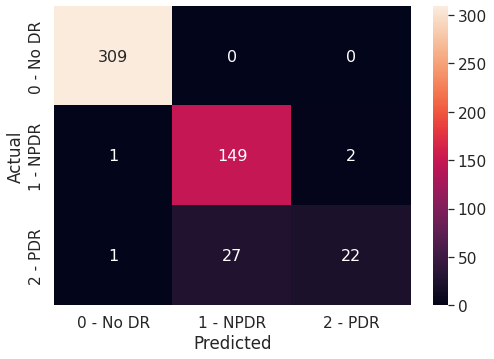

In [ ]:
labels = ['0 - No DR', '1 - NPDR', '2 - PDR']
plot_conf_matrix(list(dat['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(8,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm,  annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(list(dat['diagnosis'].astype(int)),test_labels)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(list(dat['diagnosis'].astype(int)),test_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(list(dat['diagnosis'].astype(int)),test_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(list(dat['diagnosis'].astype(int)),test_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(list(dat['diagnosis'].astype(int)),test_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(list(dat['diagnosis'].astype(int)),test_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(list(dat['diagnosis'].astype(int)),test_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(list(dat['diagnosis'].astype(int)),test_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(list(dat['diagnosis'].astype(int)),test_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(list(dat['diagnosis'].astype(int)),test_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(list(dat['diagnosis'].astype(int)),test_labels, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(list(dat['diagnosis'].astype(int)),test_labels, target_names=['Class 0', 'Class 1', 'Class 2']))

Confusion Matrix

[[309   0   0]
 [  1 149   2]
 [  1  27  22]]

Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.92
Macro Recall: 0.81
Macro F1-score: 0.83

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       309
     Class 1       0.85      0.98      0.91       152
     Class 2       0.92      0.44      0.59        50

    accuracy                           0.94       511
   macro avg       0.92      0.81      0.83       511
weighted avg       0.94      0.94      0.93       511



In [ ]:
! pip -q install pygal

In [ ]:
import pygal
from IPython.display import display, HTML
from pygal.style import RedBlueStyle

base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js"></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""
def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

def plot_cm(y_true, y_pred):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
    dot_chart.title = 'Relative test statistics'
    dot_chart.x_labels = labels
    dot_chart.x_title = "Predicted"
    dot_chart.y_title = "Actual"
    for i in range(len(labels)):
        dot_chart.add(labels[i]+' Class', cm[i,:])
    galplot(dot_chart)

plot_cm(list(dat['diagnosis']),[str(x) for x in test_labels])

# Disease detection Prediction - 2 Class Analysis

In [ ]:
def Two_class(y_data):
    strings = y_data
    new_strings = []

    for string in strings:
        new_string = string.replace("2", "1")
        new_strings.append(new_string)
    return new_strings

In [ ]:
y_pred = Two_class([str(x) for x in test_labels])
y_true = Two_class(list(dat['diagnosis']))

In [ ]:
plot_cm(y_true,y_pred)

In [ ]:
y_pred_cf = [int(x) for x in y_pred]
y_true_cf = [int(x) for x in y_true]

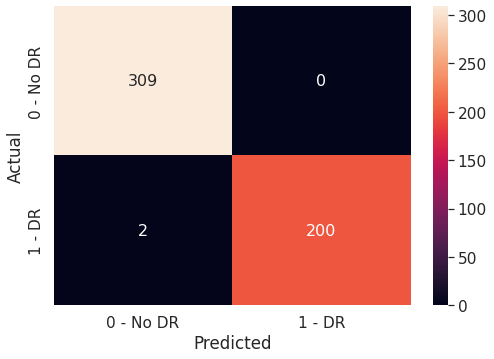

In [ ]:
labels = ['0 - No DR', '1 - DR']
plot_conf_matrix(y_true_cf,y_pred_cf,labels)

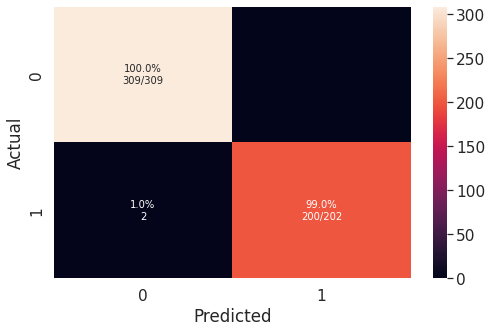

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(8,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm,  annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true_cf,y_pred_cf)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.3f}\n'.format(accuracy_score(y_true_cf,y_pred_cf)))

print('Micro Precision: {:.3f}'.format(precision_score(y_true_cf,y_pred_cf, average='micro')))
print('Micro Recall: {:.3f}'.format(recall_score(y_true_cf,y_pred_cf, average='micro')))
print('Micro F1-score: {:.3f}\n'.format(f1_score(y_true_cf,y_pred_cf, average='micro')))

print('Macro Precision: {:.3f}'.format(precision_score(y_true_cf,y_pred_cf, average='macro')))
print('Macro Recall: {:.3f}'.format(recall_score(y_true_cf,y_pred_cf, average='macro')))
print('Macro F1-score: {:.3f}\n'.format(f1_score(y_true_cf,y_pred_cf, average='macro')))

print('Weighted Precision: {:.3f}'.format(precision_score(y_true_cf,y_pred_cf, average='weighted')))
print('Weighted Recall: {:.3f}'.format(recall_score(y_true_cf,y_pred_cf, average='weighted')))
print('Weighted F1-score: {:.3f}'.format(f1_score(y_true_cf,y_pred_cf, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true_cf,y_pred_cf, target_names=['No-DR', 'DR']))

Confusion Matrix

[[309   0]
 [  2 200]]

Accuracy: 0.996

Micro Precision: 0.996
Micro Recall: 0.996
Micro F1-score: 0.996

Macro Precision: 0.997
Macro Recall: 0.995
Macro F1-score: 0.996

Weighted Precision: 0.996
Weighted Recall: 0.996
Weighted F1-score: 0.996

Classification Report

              precision    recall  f1-score   support

       No-DR       0.99      1.00      1.00       309
          DR       1.00      0.99      1.00       202

    accuracy                           1.00       511
   macro avg       1.00      1.00      1.00       511
weighted avg       1.00      1.00      1.00       511



_________________________________________________________________________________________________________________________________________________________________________